In [ ]:
pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Standard imports
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import numpy as np
malaria, info = tfds.load('malaria', split='train', with_info=True)
images = []
labels = []
for example in tfds.as_numpy(malaria):
  images.append(resize(example['image'], (32, 32)).astype(np.float32))
  labels.append(example['label'])
  if len(images) == 27558:
    break
X = np.array(images)
y = np.array(labels)
#X_v = np.array(images)
#y_v = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
    test_size=0.1111, random_state= 8) #train=80%, validation=10%, test=10%


print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteKJIDYX/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
X_train shape: (22046, 32, 32, 3)
X_test shape: (2756, 32, 32, 3)
y_train shape: (22046,)
y_test shape: (2756,)
X_val shape: (2756, 32, 32, 3)
y_val shape: (2756,)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20,
                             vertical_flip=True,
                             horizontal_flip=True)

In [ ]:
#CNN-LSTM-LSTM model

model = keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[32,32,3]),
        keras.layers.Conv2D(filters=64, kernel_size=[7,7], strides=[1,1],
                            padding="same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same",
                            activation="relu"),
         keras.layers.MaxPool2D(2),

        keras.layers.Reshape((128,-1)),

        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(64, return_sequences=True),

        keras.layers.Flatten(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(2, activation="softmax")
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Batc  (None, 32, 32, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 64)        9472      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                      

In [ ]:
opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=100, validation_data=(X_val, y_val),
          callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=0.0005, mode="min")])

Epoch 1/100
689/689 [==============================] - 15s 18ms/step - loss: 0.5222 - accuracy: 0.7243 - val_loss: 0.1891 - val_accuracy: 0.9347
Epoch 2/100
689/689 [==============================] - 12s 17ms/step - loss: 0.1843 - accuracy: 0.9423 - val_loss: 0.1434 - val_accuracy: 0.9546
Epoch 3/100
689/689 [==============================] - 12s 17ms/step - loss: 0.1540 - accuracy: 0.9507 - val_loss: 0.1349 - val_accuracy: 0.9575
Epoch 4/100
689/689 [==============================] - 12s 17ms/step - loss: 0.1433 - accuracy: 0.9551 - val_loss: 0.1323 - val_accuracy: 0.9575
Epoch 5/100
689/689 [==============================] - 12s 17ms/step - loss: 0.1416 - accuracy: 0.9528 - val_loss: 0.1215 - val_accuracy: 0.9594
Epoch 6/100
689/689 [==============================] - 12s 17ms/step - loss: 0.1335 - accuracy: 0.9566 - val_loss: 0.1121 - val_accuracy: 0.9630
Epoch 7/100
689/689 [==============================] - 12s 17ms/step - loss: 0.1276 - accuracy: 0.9577 - val_loss: 0.1692 - val_ac

In [ ]:
model.evaluate(X_test, y_test)

87/87 [==============================] - 1s 6ms/step - loss: 0.1286 - accuracy: 0.9565


[0.12862412631511688, 0.9564586281776428]

In [ ]:
y_pred= np.argmax(model.predict(X_test), axis=1)
y_pred

87/87 [==============================] - 1s 5ms/step


array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
y_pred
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
cm

array([[1331,   54],
       [  66, 1305]])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1385
           1       0.96      0.95      0.96      1371

    accuracy                           0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756



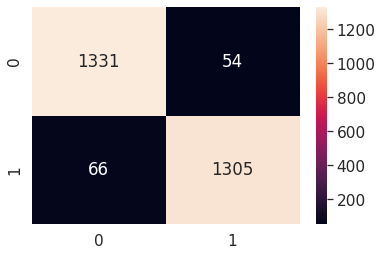

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

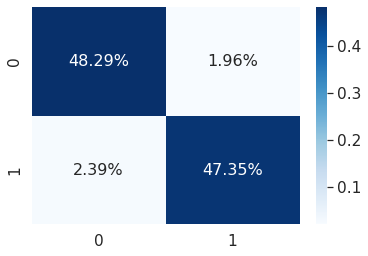

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues', annot_kws={"fontsize":16})
sns.set(font_scale=1.4)

# Save the image to a file
plt.savefig('CNN-LSTM-LSTM.pdf')
plt.show()

# Download the image file
from google.colab import files
files.download('CNN-LSTM-LSTM.pdf')

In [ ]:
#CNN-GRU-GRU model

model = keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[32,32,3]),
        keras.layers.Conv2D(filters=64, kernel_size=[7,7], strides=[1,1],
                            padding="same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same",
                            activation="relu"),
         keras.layers.MaxPool2D(2),

        keras.layers.Reshape((128,-1)),

        keras.layers.GRU(128, return_sequences=True),
        keras.layers.GRU(64, return_sequences=True),

        keras.layers.Flatten(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(2, activation="softmax")
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 32, 32, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        9472      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                      

In [ ]:
opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=100, validation_data=(X_val, y_val),
          callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=0.0005, mode="min")])

Epoch 1/100
689/689 [==============================] - 18s 21ms/step - loss: 0.4555 - accuracy: 0.7670 - val_loss: 0.1677 - val_accuracy: 0.9463
Epoch 2/100
689/689 [==============================] - 13s 20ms/step - loss: 0.1739 - accuracy: 0.9445 - val_loss: 0.1402 - val_accuracy: 0.9568
Epoch 3/100
689/689 [==============================] - 14s 20ms/step - loss: 0.1504 - accuracy: 0.9515 - val_loss: 0.1326 - val_accuracy: 0.9604
Epoch 4/100
689/689 [==============================] - 13s 19ms/step - loss: 0.1433 - accuracy: 0.9526 - val_loss: 0.1625 - val_accuracy: 0.9554
Epoch 5/100
689/689 [==============================] - 13s 19ms/step - loss: 0.1391 - accuracy: 0.9548 - val_loss: 0.1241 - val_accuracy: 0.9583
Epoch 6/100
689/689 [==============================] - 13s 19ms/step - loss: 0.1347 - accuracy: 0.9561 - val_loss: 0.1390 - val_accuracy: 0.9568
Epoch 7/100
689/689 [==============================] - 13s 19ms/step - loss: 0.1289 - accuracy: 0.9565 - val_loss: 0.1201 - val_ac

In [ ]:
model.evaluate(X_test, y_test)

87/87 [==============================] - 1s 6ms/step - loss: 0.1291 - accuracy: 0.9601


[0.12912946939468384, 0.9600870609283447]

In [ ]:
y_pred= np.argmax(model.predict(X_test), axis=1)
y_pred

87/87 [==============================] - 1s 5ms/step


array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
y_pred
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
cm

array([[1335,   50],
       [  60, 1311]])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1385
           1       0.96      0.96      0.96      1371

    accuracy                           0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756



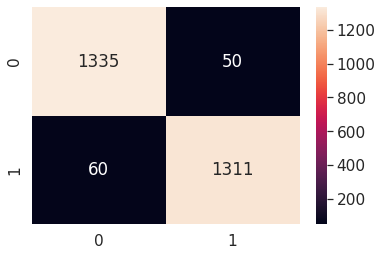

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

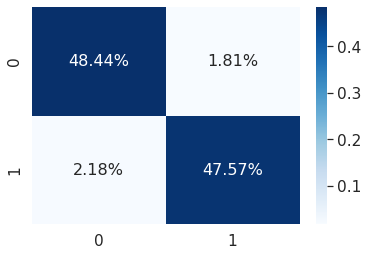

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues', annot_kws={"fontsize":16})
sns.set(font_scale=1.4)

# Save the image to a file
plt.savefig('CNN-GRU-GRU.pdf')
plt.show()

# Download the image file
from google.colab import files
files.download('CNN-GRU-GRU.pdf')

In [ ]:
#CNN-BiLSTM-BiLSTM model

model = keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[32,32,3]),
        keras.layers.Conv2D(filters=64, kernel_size=[7,7], strides=[1,1],
                            padding="same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same",
                            activation="relu"),
         keras.layers.MaxPool2D(2),

        keras.layers.Reshape((128,-1)),

        keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

        keras.layers.Flatten(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(2, activation="softmax")
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 32, 32, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        9472      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                      

In [ ]:
opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=100, validation_data=(X_val, y_val),
          callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=0.0005, mode="min")])

Epoch 1/100
689/689 [==============================] - 23s 25ms/step - loss: 0.6492 - accuracy: 0.6201 - val_loss: 0.6410 - val_accuracy: 0.6542
Epoch 2/100
689/689 [==============================] - 16s 23ms/step - loss: 0.6167 - accuracy: 0.6657 - val_loss: 0.6876 - val_accuracy: 0.4837
Epoch 3/100
689/689 [==============================] - 16s 23ms/step - loss: 0.6682 - accuracy: 0.5885 - val_loss: 0.6064 - val_accuracy: 0.6894
Epoch 4/100
689/689 [==============================] - 16s 23ms/step - loss: 0.6163 - accuracy: 0.6674 - val_loss: 0.6500 - val_accuracy: 0.6332
Epoch 5/100
689/689 [==============================] - 16s 23ms/step - loss: 0.5972 - accuracy: 0.6863 - val_loss: 0.5433 - val_accuracy: 0.7221
Epoch 6/100
689/689 [==============================] - 16s 23ms/step - loss: 0.3705 - accuracy: 0.8465 - val_loss: 1.3215 - val_accuracy: 0.5334
Epoch 7/100
689/689 [==============================] - 16s 23ms/step - loss: 0.6901 - accuracy: 0.5319 - val_loss: 0.6833 - val_ac

In [ ]:
model.evaluate(X_test, y_test)

87/87 [==============================] - 1s 9ms/step - loss: 0.1764 - accuracy: 0.9376


[0.17636623978614807, 0.9375907182693481]

In [ ]:
y_pred= np.argmax(model.predict(X_test), axis=1)
y_pred

87/87 [==============================] - 2s 9ms/step


array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
y_pred
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
cm

array([[1317,   68],
       [ 104, 1267]])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1385
           1       0.95      0.92      0.94      1371

    accuracy                           0.94      2756
   macro avg       0.94      0.94      0.94      2756
weighted avg       0.94      0.94      0.94      2756



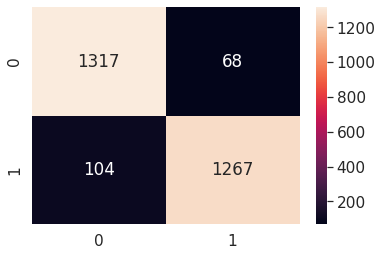

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

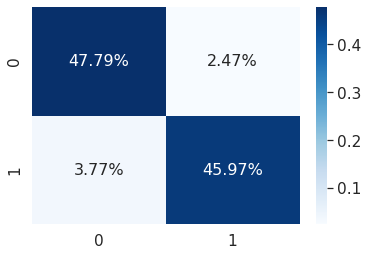

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues', annot_kws={"fontsize":16})
sns.set(font_scale=1.4)

# Save the image to a file
plt.savefig('CNN-BiLSTM-BiLSTM.pdf')
plt.show()

# Download the image file
from google.colab import files
files.download('CNN-BiLSTM-BiLSTM.pdf')